In [40]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [36]:
def plot_series(time, series, format="-", start=0, end=None):
    
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      plt.plot(time[start:end], series[start:end], format)

    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()


def extract_last_4_chars(value):
    return value[-4:]


def windowed_dataset(series, window_size, batch_size, shuffle_buffer):

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [2]:
data = pd.read_csv("GDP_Dataset.csv")
data.head()

,date,GDP,Per Capita,Growthannualchange
0,31/12/1960,3.749265,81.5869,NaN
1,31/12/1961,4.118648,87.5174,5.9873
2,31/12/1962,4.310164,89.4933,4.4829
3,31/12/1963,4.630827,93.8839,8.6888
4,31/12/1964,5.204956,102.9612,7.5698


In [5]:
mean_val = data[' Growthannualchange'].mean()
mean_val

5.059570967741935

In [6]:
data[' Growthannualchange'].fillna(mean_val, inplace=True)
data.head()

,date,GDP,Per Capita,Growthannualchange
0,31/12/1960,3.749265,81.5869,5.059571
1,31/12/1961,4.118648,87.5174,5.987300
2,31/12/1962,4.310164,89.4933,4.482900
3,31/12/1963,4.630827,93.8839,8.688800
4,31/12/1964,5.204956,102.9612,7.569800


In [8]:
train_dates = pd.to_datetime(data["date"])

C:\Users\haris\AppData\Local\Temp\ipykernel_30044\90571183.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  train_dates = pd.to_datetime(data["date"])


In [10]:
cols = list(data)[1:4]

In [12]:
df_for_training = data[cols].astype(float)

In [13]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [24]:
trainx = []
trainy = []

n_futures = 1
n_past = 9

for i in range (n_past, len(df_for_training_scaled) - n_futures + 1):
    trainx.append(df_for_training_scaled [i - n_past:i, 0:df_for_training.shape[1]]) 
    trainy.append(df_for_training_scaled [i+ n_futures - 1: i + n_futures, 0])

In [28]:
trainx = np.array(trainx)
trainy = np.array(trainy)

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, activation= 'relu', input_shape=(trainx.shape[1], trainx.shape[2]), return_sequences= True),
    tf.keras.layers.LSTM(32, activation= 'relu', return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense (trainy.shape[1])
])

model.compile(optimizer='adam', 
              loss='mse', 
              metrics= 'accuracy')
 
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 9, 64)             17408     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = model.fit(trainx, trainy, epochs= 50, batch_size= 16, validation_split=0.1)

Epoch 1/50
3/3 [==============================] - 0s 54ms/step - loss: 0.1438 - accuracy: 0.0000e+00 - val_loss: 0.5595 - val_accuracy: 0.0000e+00
Epoch 2/50
3/3 [==============================] - 0s 41ms/step - loss: 0.0907 - accuracy: 0.0000e+00 - val_loss: 0.5994 - val_accuracy: 0.0000e+00
Epoch 3/50
3/3 [==============================] - 0s 38ms/step - loss: 0.0609 - accuracy: 0.0000e+00 - val_loss: 7.2801 - val_accuracy: 0.0000e+00
Epoch 4/50
3/3 [==============================] - 0s 32ms/step - loss: 0.0550 - accuracy: 0.0000e+00 - val_loss: 17.8458 - val_accuracy: 0.0000e+00
Epoch 5/50
3/3 [==============================] - 0s 34ms/step - loss: 0.1421 - accuracy: 0.0000e+00 - val_loss: 7.0149 - val_accuracy: 0.0000e+00
Epoch 6/50
3/3 [==============================] - 0s 36ms/step - loss: 0.0674 - accuracy: 0.0000e+00 - val_loss: 1.8428 - val_accuracy: 0.0000e+00
Epoch 7/50
3/3 [==============================] - 0s 32ms/step - loss: 0.0595 - accuracy: 0.0000e+00 - val_loss: 0.90

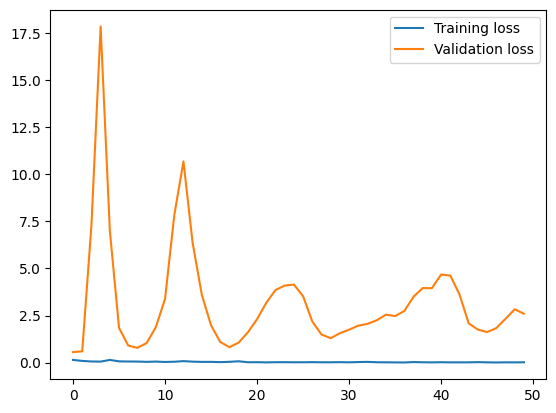

In [38]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [41]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

prediction = model.predict(trainx[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'date':np.array(forecast_dates), ' GDP':y_pred_future})
df_forecast['date']=pd.to_datetime(df_forecast['date'])


original = data[['date', ' GDP']]
original['date']=pd.to_datetime(original['date'])
original = original.loc[original['date'] >= '2020-5-1']

sns.lineplot(original['date'], original[' GDP'])
sns.lineplot(df_forecast['date'], df_forecast[' GDP'])

[Timestamp('2007-12-31 00:00:00'), Timestamp('2008-01-02 00:00:00'), Timestamp('2008-01-03 00:00:00'), Timestamp('2008-01-04 00:00:00'), Timestamp('2008-01-07 00:00:00'), Timestamp('2008-01-08 00:00:00'), Timestamp('2008-01-09 00:00:00'), Timestamp('2008-01-10 00:00:00'), Timestamp('2008-01-11 00:00:00'), Timestamp('2008-01-14 00:00:00'), Timestamp('2008-01-15 00:00:00'), Timestamp('2008-01-16 00:00:00'), Timestamp('2008-01-17 00:00:00'), Timestamp('2008-01-18 00:00:00'), Timestamp('2008-01-22 00:00:00')]
1/1 [==============================] - 0s 209ms/step


C:\Users\haris\AppData\Local\Temp\ipykernel_30044\2088533562.py:25: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  original['date']=pd.to_datetime(original['date'])
C:\Users\haris\AppData\Local\Temp\ipykernel_30044\2088533562.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['date']=pd.to_datetime(original['date'])


TypeError: lineplot() takes from 0 to 1 positional arguments but 2 were given